# Superposed SRC(SSRC)
* This notebook reproduced (part of) experiments in this paper

W. Deng, J. Hu and J. Guo, "In Defense of Sparsity Based Face Recognition," 2013 IEEE Conference on Computer Vision and Pattern Recognition, Portland, OR, 2013, pp. 399-406, doi: 10.1109/CVPR.2013.58.
https://ieeexplore.ieee.org/document/6618902

* Data source: AR face data files
    * It can be download from http://cbcsl.ece.ohio-state.edu/protected-dir/AR_warp_zip.zip upon authorization.
    * To get authorization, visit http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html

In [43]:
import sys
import warnings
warnings.simplefilter("ignore")
import numpy as np
from PIL import Image
import os, sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import time
import random
import sklearn
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from semisupervised import SSGMM

### Load in images

In [44]:
def read_images(path,resize=False,length = 165, width = 120 ):
    X, y = [], []
    for filename in os.listdir(path):
        if filename.endswith(".bmp"):
            im = Image.open(path+'/'+filename)
            im = im.convert("L")
            if resize and (im.size[0]!=width or im.size[1]!=length):
                im = im.resize((width,length),Image.NEAREST)
                
            X.append(np.asarray(im,dtype=np.uint8))
            if filename[0]=="M":
                subject_class = int(filename[2:5]) - 1
            if filename[0]=="W":
                subject_class = int(filename[2:5]) - 1 + 50
            y.append(subject_class)
    return X,y   
X, y = read_images(path="E:/AR_warp_zip/test2", resize = True)
X_list =  [i.flatten() for i in X]
X_arr = np.stack(X_list,axis=1)
X_arr = sklearn.preprocessing.normalize(X_arr,axis=1)
print("Dataset shape:", X_arr.shape)

Dataset shape: (19800, 2600)


### Seperate Train and test

5 samples for training/21 samples for testing, in each class
500 samples for training/2100 samples for testing, in the whole set


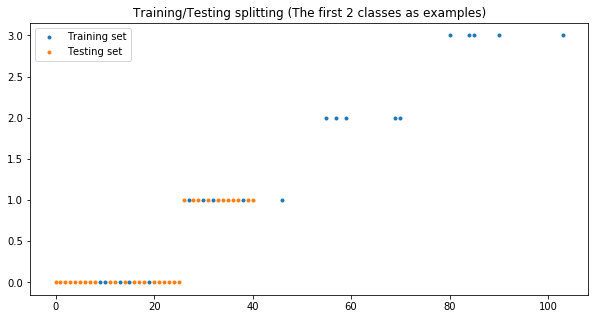

In [45]:
def seperate_train_test(k_train,n_per_person = 26,n_person = 100):
    index_train = []
    index_test = []
    for i in range(n_person):
        index_train_person = random.sample(range(n_per_person), k = k_train)
        index_test_person = [i for i in range(n_per_person) if i not in index_train_person]
        index_train_person = (np.array(index_train_person)+n_per_person*i).tolist()
        index_test_person = (np.array(index_test_person)+n_per_person*i).tolist()
        index_train.extend(index_train_person)
        index_test.extend(index_test_person)
    return index_train, index_test

n_person = 100
k_train = 5
n_per_person = 26
index_train, index_test = seperate_train_test(k_train=k_train,n_per_person = n_per_person,n_person = n_person)
y_train = np.array(y)[index_train].tolist()
y_test = np.array(y)[index_test].tolist()
X_train = X_arr[:,np.array(index_train)]
X_test = X_arr[:,np.array(index_test)]
print("{} samples for training/{} samples for testing, in each class".format(k_train, n_per_person-k_train))
print("{} samples for training/{} samples for testing, in the whole set".format(len(index_train), len(index_test)))


plt.figure(figsize=(10,5))
plt.plot(index_train[:20], y_train[:20],'.',label = "Training set")
plt.plot(index_test[:32], y_test[:32],'.',label ="Testing set")
plt.title("Training/Testing splitting (The first 2 classes as examples)")
plt.legend()
plt.show()

### Gallery plus Variance Framework
* P: Gallery dictionary --> Intialized by centrioid of the labeled data in each class
* V: Variance dictionary --> Subtract corresponding centriods from all of the labeld data

In [46]:
def gallery_variance(X_train, n_person, k_train):
    P = np.zeros((X_train.shape[0],n_person))
    P_redundant = np.zeros_like(X_train)
    for i in range(n_person):
        centroid = np.mean(X_train[:,k_train*i:k_train*(i+1)], axis=1)
        P[:,i] = centroid
        P_redundant[:, i*k_train:(i+1)*k_train] = np.stack([centroid]*k_train,  axis= 1) 
    V = X_train - P_redundant
    return P, V
P, V = gallery_variance(X_train, n_person, k_train)
print("Shape of gallery dictionary:", P.shape)
print("Shape of variance dictionary:", V.shape)

Shape of gallery dictionary: (19800, 100)
Shape of variance dictionary: (19800, 500)


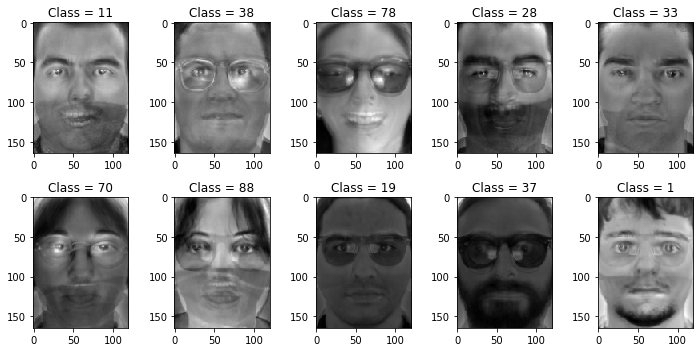

In [47]:
# Visualize some of the centroids (atoms of gallery dictionary)
index_visualize_p = random.sample(range(n_person), k = 10)
f, ax = plt.subplots(2,5,figsize=(10,5), squeeze = False)
for i in range(2):
    for j in range(5):
        k = i*5+j
        ax[i,j].imshow(np.reshape(P[:,index_visualize_p[k]],(165,120)), cmap = "gray")
        ax[i,j].set_title("Class = "+ str(index_visualize_p[k]))
f.tight_layout()

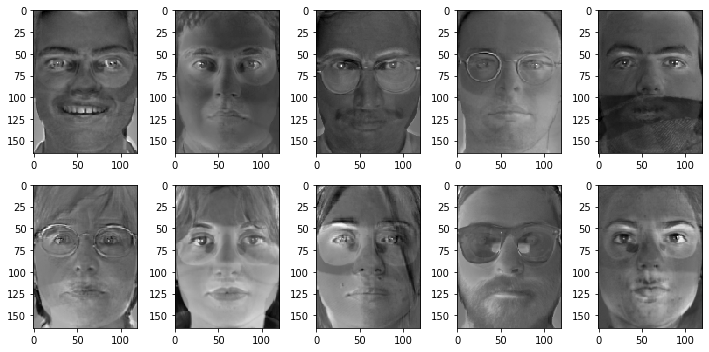

In [48]:
# Visualize some of the variance (atoms of variance dictionary)
index_visualize_v = random.sample(range(V.shape[1]), k = 10)
f, ax = plt.subplots(2,5,figsize=(10,5), squeeze = False)
for i in range(2):
    for j in range(5):
        k = i*5+j
        ax[i,j].imshow(np.reshape(V[:,index_visualize_v[k]],(165,120)), cmap = "gray")
        #ax[i,j].set_title("Class = "+ str(index_visualize[k]))
f.tight_layout()

### Dimension reduction and normalize
* Dimension reduction: Use PCA, top-300 features
* Normalize: Each sample has unit L-2 norm

In [49]:
def compute_residual(x,P,V,alpha,beta):
    # x:300 x 1
    # P:300 x 100
    # V:300 x N
    # alpha: 100 x 1
    # beta:  N x 1
    # residual : 100 x 1
    #print(x.shape, P.shape, V.shape, alpha.shape, beta.shape)
    n_person = alpha.shape[0]
    variance = np.dot(V,beta)
    x_hat = [alpha[i]*P[:,i] for i in range(n_person)]
    x_hat = np.stack(x_hat,axis=1)
    error = x_hat - np.stack([x]*n_person, axis=1)+np.stack([variance]*n_person, axis=1)
    residual = np.linalg.norm(error,ord = 2, axis = 0)
    return residual

In [50]:
pca = PCA(n_components = 300)
pca.fit(X_train.T)
P = pca.transform(P.T)
V = pca.transform(V.T)
X_train = pca.transform(X_train.T)
X_test = pca.transform(X_test.T)

P = sklearn.preprocessing.normalize(P)
V = sklearn.preprocessing.normalize(V)
X_train = sklearn.preprocessing.normalize(X_train)
X_test = sklearn.preprocessing.normalize(X_test)

print("shape of P", P.shape)
print("shape of V", V.shape)
print("shape of X_train", X_train.shape)
print("shape of X_test", X_test.shape)

shape of P (100, 300)
shape of V (500, 300)
shape of X_train (500, 300)
shape of X_test (2100, 300)


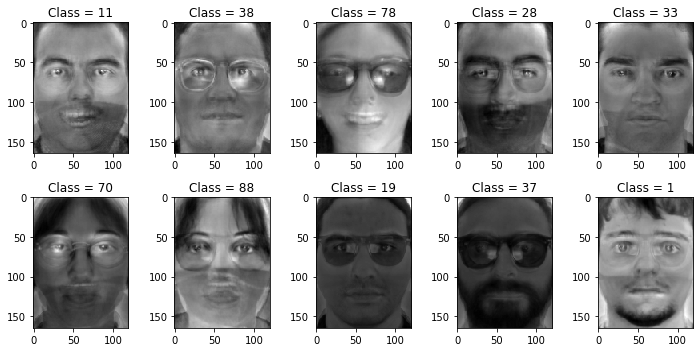

In [51]:
# Visualize PCA reconstruction results of P
f, ax = plt.subplots(2,5,figsize=(10,5), squeeze = False)
for i in range(2):
    for j in range(5):
        k = i*5+j
        reconstruct_vector = pca.inverse_transform(P[index_visualize_p[k],:])
        ax[i,j].imshow(np.reshape(reconstruct_vector,(165,120)), cmap = "gray")
        ax[i,j].set_title("Class = "+ str(index_visualize_p[k]))
f.tight_layout()

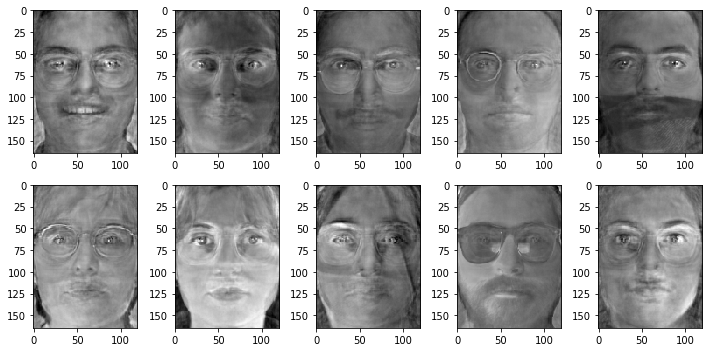

In [52]:
# Visualize PCA reconstruction results of V
f, ax = plt.subplots(2,5,figsize=(10,5), squeeze = False)
for i in range(2):
    for j in range(5):
        k = i*5+j
        reconstruct_vector = pca.inverse_transform(V[index_visualize_v[k],:])
        ax[i,j].imshow(np.reshape(reconstruct_vector,(165,120)), cmap = "gray")
        #ax[i,j].set_title("Class = "+ str(index_visualize_p[k]))
f.tight_layout()

### Example

(100,) (500,)


Text(0.5, 1.0, 'Predicted prototype image')

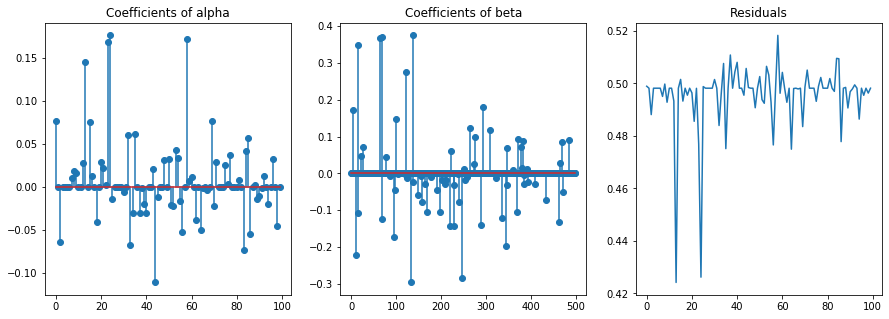

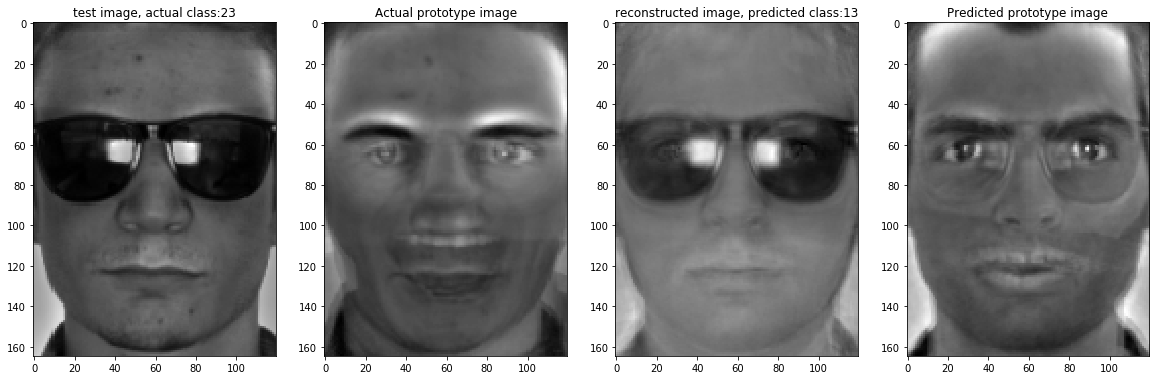

In [53]:
i=random.choice(range(1000))

clf = Lasso(alpha = 0.005/(2*300))
clf.fit(np.concatenate((P.T,V.T), axis=1), X_test.T[:,i])
alpha_hat = clf.coef_[:n_person]
beta_hat = clf.coef_[n_person:]
print(alpha_hat.shape, beta_hat.shape)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.stem(alpha_hat)
plt.title("Coefficients of alpha")

plt.subplot(1,3,2)
plt.stem(beta_hat)
plt.title("Coefficients of beta")

residual = compute_residual(X_test.T[:,i],P.T, V.T, alpha_hat,beta_hat)
plt.subplot(1,3,3)
plt.plot(residual)
plt.title("Residuals")


actual_class = y_test[i]
predict_class = np.argmin(residual)

plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
plt.imshow(X_arr[:,index_test[i]].reshape((165,120)),cmap="gray")
plt.title("test image, actual class:"+str(actual_class))

protoimage = pca.inverse_transform(P.T[:,actual_class])
plt.subplot(1,4,2)
plt.imshow(protoimage.reshape((165,120)),cmap="gray")
plt.title("Actual prototype image")


reconstruct_vector = sklearn.preprocessing.normalize((alpha_hat[predict_class]*P.T[:,predict_class]+np.dot(V.T,beta_hat)).reshape(1,-1),axis=1)
reconstruct_image = pca.inverse_transform(reconstruct_vector)
plt.subplot(1,4,3)
plt.imshow(reconstruct_image.reshape((165,120)),cmap="gray")
plt.title("reconstructed image, predicted class:"+str(predict_class))

protoimage = pca.inverse_transform(P.T[:,predict_class])
plt.subplot(1,4,4)
plt.imshow(protoimage.reshape((165,120)),cmap="gray")
plt.title("Predicted prototype image")


### Qauntitative results

In [54]:
clf = Lasso(alpha = 0.005/(2*300))
clf.fit(np.concatenate((P.T,V.T), axis=1), X_test.T)
alpha_hat = clf.coef_[:,:n_person]
beta_hat = clf.coef_[:,n_person:]

In [55]:
Residual = np.zeros((n_person,X_test.shape[0]))
for i in range(X_test.shape[0]):
    Residual[:,i] = compute_residual(X_test.T[:,i],P.T, V.T, alpha_hat.T[:,i],beta_hat.T[:,i])

In [56]:
# Calulate the accuracy
y_hat = np.argmin(Residual,axis=0)
np.sum(y_hat==np.array(y_test))/len(y_test)

0.8066666666666666

*  Fine ! Training on 5 samples/each person, we still get 0.807 accuracy!

Text(0, 0.5, 'Labels')

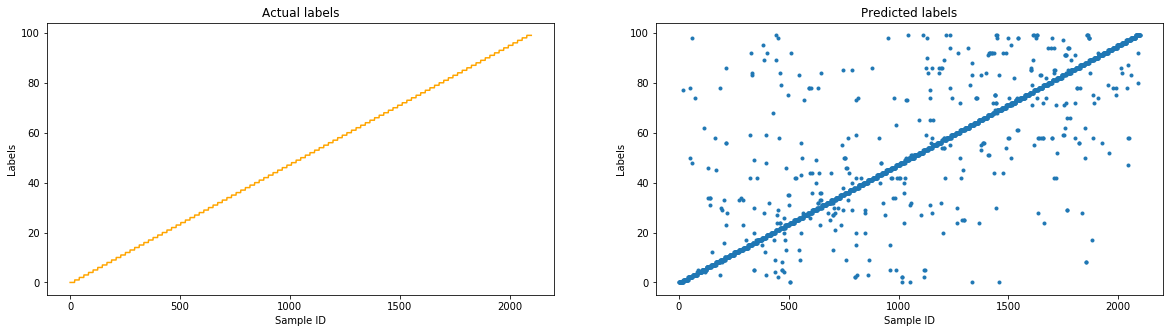

In [57]:
# Visualize the final output
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.plot(y_test,'orange')
plt.title("Actual labels")
plt.xlabel("Sample ID")
plt.ylabel("Labels")
plt.subplot(1,2,2)
plt.plot(y_hat,'.')
plt.title("Predicted labels")
plt.xlabel("Sample ID")
plt.ylabel("Labels")

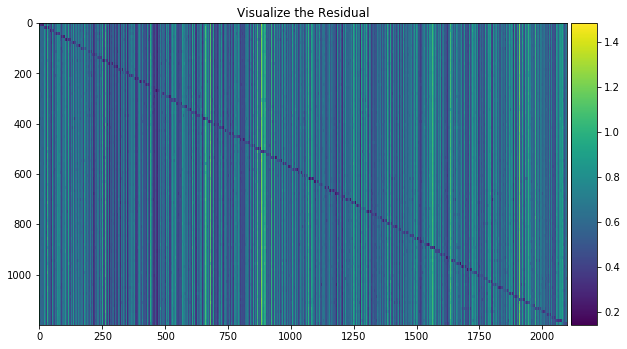

In [58]:
Residual_show = np.zeros((12*n_person,Residual.shape[1]))
for i in range(n_person):
    Residual_show[i*12:(i+1)*12,:] = Residual[i,:]
from mpl_toolkits.axes_grid1 import make_axes_locatable
f, ax = plt.subplots(figsize=(10,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
im = ax.imshow(Residual_show)
f.colorbar(im,cax=cax,orientation ="vertical")
ax.set_title("Visualize the Residual")
plt.show()